In [1]:
# First, Import all required Data,(MANDATORY)
# import data by URL: https://www.kaggle.com/datasets/awsaf49/brats20-dataset-training-validation
# import data by URL: https://www.kaggle.com/datasets/atulsingh1996/cse676-brats-semantic-segmentation

#ONLY EDIT THIS SECTION - BEGIN

# MODE can be 'TRAIN_FRESH' or 'EVALUATE'
# To do fresh training followed by its evaluation, Set to TRAIN_FRESH
# To only evaluate our pre-trained model, Set to EVALUATE
MODE = 'TRAIN_FRESH'

# This is the model architecture you want to train or test. It can only take the following values.
#'simpleUNET', 'resNETUNET', 'WNET', 'UNETVAE', 'VGG19', 'InceptionV3', 'InceptionResNetV2'
CURRENT_MODEL = 'InceptionV3'


#ONLY EDIT THIS SECTION - END

In [2]:
!pip install segmentation-models
!pip install nilearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 KB 4.1 MB/s eta 0:00:00


In [3]:
!jupyter --version

Selected Jupyter core packages...
IPython          : 7.32.0
ipykernel        : 6.9.2
ipywidgets       : 7.6.5
jupyter_client   : 7.1.2
jupyter_core     : 4.9.2
jupyter_server   : 1.15.4
jupyterlab       : 3.2.9
nbclient         : 0.5.13
nbconvert        : 6.5.0
nbformat         : 5.2.0
notebook         : 6.4.10
qtconsole        : 5.2.2
traitlets        : 5.1.1


In [4]:
import nilearn
import nibabel as nib
import nilearn.plotting as nlplt

In [5]:
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage
from skimage.transform import rotate
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import random
import pandas as pd

# Segmentation Models
import segmentation_models as sm

# Keras
import tensorflow as tf
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers.experimental import preprocessing

np.set_printoptions(precision=3, suppress=True)

Segmentation Models: using `keras` framework.


In [6]:
TRAINING_DATASET = "../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*"

IMAGE_DIR = glob.glob(TRAINING_DATASET)
CSV_LIST = glob.glob(TRAINING_DATASET + 'csv')
for i in CSV_LIST:
    IMAGE_DIR.remove(i)

IMAGE_DIR.remove(TRAINING_DATASET.replace("*", "") + 'BraTS20_Training_355')
IMAGE_DIR = IMAGE_DIR[0:100]

TRAIN_LIST, VAL_LIST = train_test_split(IMAGE_DIR, test_size=0.2)
TRAIN_LIST, TEST_LIST = train_test_split(TRAIN_LIST, test_size=0.3)

VIEW_IMG_IDX = random.randint(0, len(TRAIN_LIST) - 1)
LIST_DATA = sorted(glob.glob(TRAIN_LIST[VIEW_IMG_IDX] + '/*'))
VIEW_IMAGE = {
    'flair': nib.load(LIST_DATA[0]).get_fdata(),
    't1': nib.load(LIST_DATA[2]).get_fdata(),
    't1ce': nib.load(LIST_DATA[3]).get_fdata(),
    't2': nib.load(LIST_DATA[4]).get_fdata(),
    'mask': nib.load(LIST_DATA[1]).get_fdata()
}

MODEL = {
    'simpleUNET': 'simpleUNET.h5',
    'resNETUNET': 'resnetUNET.h5',
    'WNET': 'WNET.h5',
    'UNETVAE': 'UNETVAE.h5',
    'VGG19': 'VGG19.h5',
    'InceptionV3': 'InceptionV3.h5',
    'InceptionResNetV2': 'InceptionResNetV2.h5'
#     'EffUNet': 'EffUNet.h5'
}
LOG = {
    'simpleUNET': 'simpleUNET_training.log',
    'resNETUNET': 'resnetUNET_training.log',
    'WNET': 'WNET_training.log',
    'UNETVAE': 'UNETVAE_training.log',
    'VGG19': 'VGG19_training.log',
    'InceptionV3': 'InceptionV3_training.log',
    'InceptionResNetV2': 'InceptionResnetV2_training.log'
    'EffUNet_training.log'
}

SEGMENT_CLASSES = {
    0: 'NOT tumor',
    1: 'NECROTIC/CORE',
    2: 'EDEMA',
    3: 'ENHANCING'
}
SAVED_MODEL = {
    'WNET': '../input/wnetmodel/WNET.h5',
    'resNETUNET': '../input/resnet-unet-trained-model/resnetUNET.h5',
    'simpleUNET': '../input/simpleunet/simpleUNet.h5',
    'VGG19': '../input/vgg19v2/VGG19.h5',
    'InceptionV3': '../input/inceptionv3/InceptionV3.h5',
    'InceptionResNetV2': '../input/inceptionresnetv2/InceptionResNetV2.h5'
#     'EffUNet': '../input/eff-unet-model/EffUNet.h5'
}
SLICES_VOL = 100
VOL_START = 22
IMG_SIZE = 128

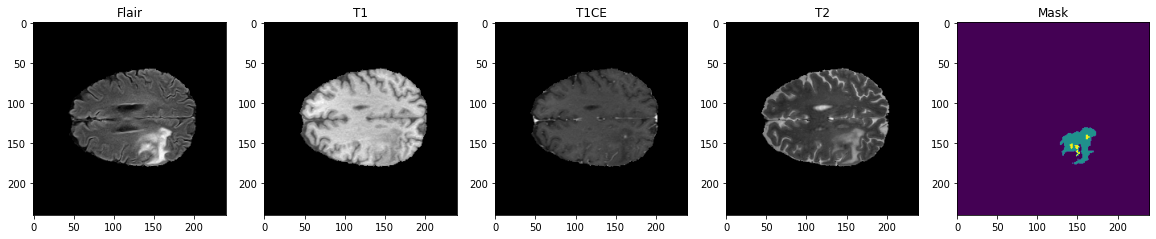

In [7]:
def analyse_initial_data():
    fig, (axis1, axis2, axis3, axis4, axis5) = plt.subplots(1, 5, figsize=(20, 10))
    slice_w = 25
    axis1.imshow(VIEW_IMAGE['flair'][:, :,
               VIEW_IMAGE['flair'].shape[0]//2 - slice_w], cmap='gray')
    axis1.set_title('Flair')
    axis2.imshow(
        VIEW_IMAGE['t1'][:, :, VIEW_IMAGE['t1'].shape[0]//2 - slice_w], cmap='gray')
    axis2.set_title('T1')
    axis3.imshow(
        VIEW_IMAGE['t1ce'][:, :, VIEW_IMAGE['t1ce'].shape[0]//2 - slice_w], cmap='gray')
    axis3.set_title('T1CE')
    axis4.imshow(
        VIEW_IMAGE['t2'][:, :, VIEW_IMAGE['t2'].shape[0]//2 - slice_w], cmap='gray')
    axis4.set_title('T2')
    axis5.imshow(VIEW_IMAGE['mask']
               [:, :, VIEW_IMAGE['mask'].shape[0]//2 - slice_w])
    axis5.set_title('Mask')


analyse_initial_data()

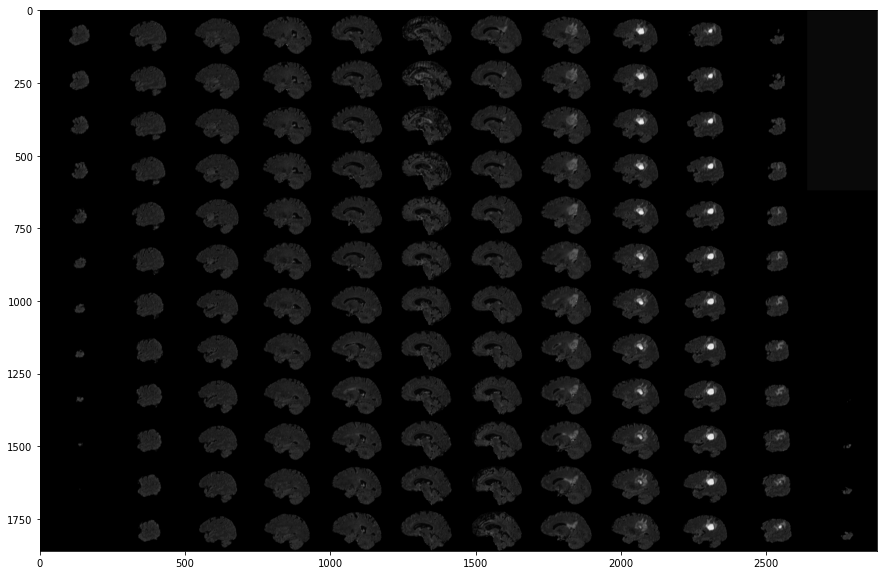

In [8]:
def show_montage():
    fig, axis = plt.subplots(1, 1, figsize=(15, 15))
    axis.imshow(rotate(
        montage(VIEW_IMAGE['flair'][50:-50, :, :]), 90, resize=True), cmap='gray')


show_montage()

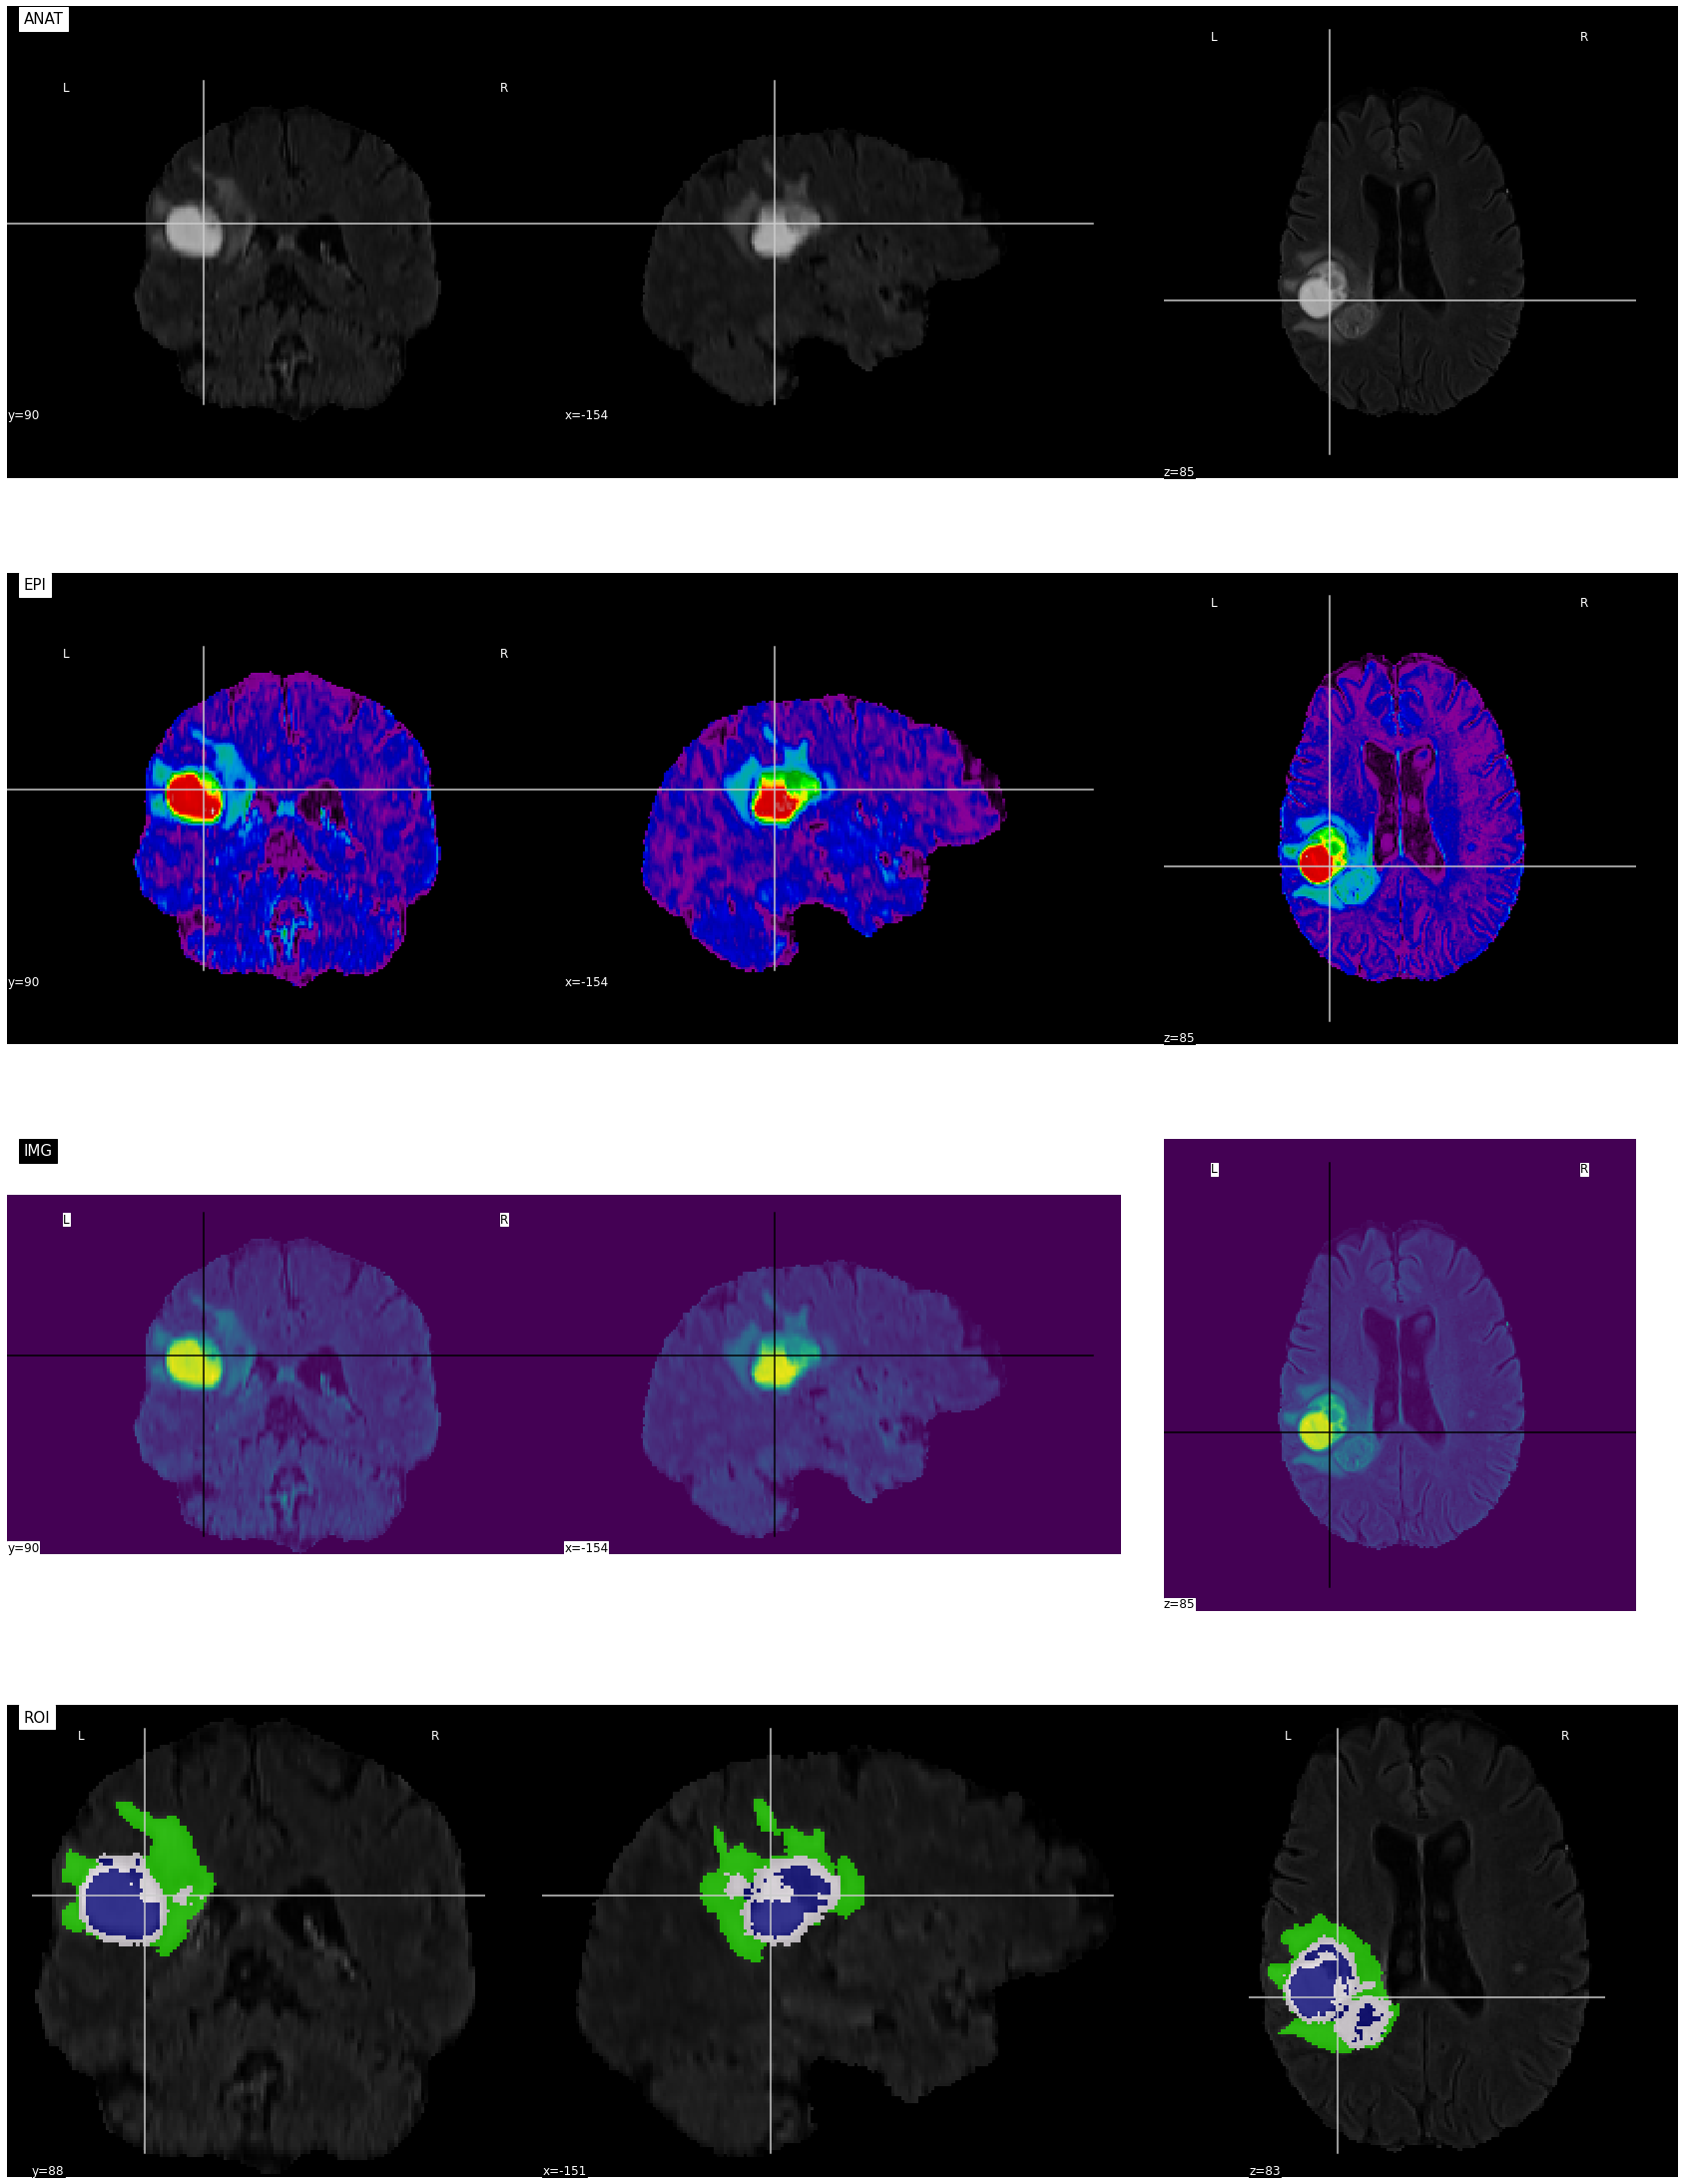

In [9]:
def show_mri_diagram():
    image = nilearn.image.load_img(LIST_DATA[0])
    mask = nilearn.image.load_img(LIST_DATA[1])
    fig, axes = plt.subplots(nrows=4, figsize=(30, 40))
    nlplt.plot_anat(image, title='ANAT', axes=axes[0])
    nlplt.plot_epi(image, title='EPI', axes=axes[1])
    nlplt.plot_img(image, title='IMG', axes=axes[2])
    nlplt.plot_roi(mask, title='ROI', bg_img=image, axes=axes[3])
    plt.show()


show_mri_diagram()

In [10]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

class DataGenerator(keras.utils.all_utils.Sequence):
    def __init__(self, list_IDs, dimensions=(IMG_SIZE, IMG_SIZE), batch_size=1, n_channels=2, shuffle=True):
        self.dimensions = dimensions
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        Batch_ids = [self.list_IDs[k] for k in indexes]
        X, y = self.__data_generation(Batch_ids)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        X = np.zeros((self.batch_size*SLICES_VOL,
                     *self.dimensions, self.n_channels))
        y = np.zeros((self.batch_size*SLICES_VOL, 240, 240))
        Y = np.zeros((self.batch_size*SLICES_VOL, *self.dimensions, 4))
        for c, i in enumerate(Batch_ids):
            base_path = i
            data = base_path.split('/')[-1]
            data_path = f'{i}/{data}_flair.nii'
            flair = nib.load(data_path).get_fdata()
            flair = scaler.fit_transform(
                flair.reshape(-1, flair.shape[-1])).reshape(flair.shape)

            base_path = i
            data = base_path.split('/')[-1]
            data_path = f'{i}/{data}_t1ce.nii'
            ce = nib.load(data_path).get_fdata()
            ce = scaler.fit_transform(
                ce.reshape(-1, ce.shape[-1])).reshape(ce.shape)

            base_path = i
            data = base_path.split('/')[-1]
            data_path = f'{i}/{data}_seg.nii'
            seg = nib.load(data_path).get_fdata()

            for j in range(SLICES_VOL):
                X[j + SLICES_VOL*c, :, :,
                    0] = cv2.resize(flair[:, :, j+VOL_START], (IMG_SIZE, IMG_SIZE))
                X[j + SLICES_VOL*c, :, :,
                    1] = cv2.resize(ce[:, :, j+VOL_START], (IMG_SIZE, IMG_SIZE))
                y[j + SLICES_VOL*c] = seg[:, :, j+VOL_START]

        y[y == 4] = 3
        mask = tf.one_hot(y, 4)
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE))
        return X / np.max(X), Y


training_generator = DataGenerator(TRAIN_LIST)
val_generator = DataGenerator(VAL_LIST)
test_generator = DataGenerator(TEST_LIST)

# **Data Augmentation**

In [11]:
# import tensorflow as tf
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# import numpy as np
# import cv2
# import nibabel as nib
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()

# class DataGenerator(keras.utils.all_utils.Sequence):
#     def __init__(self, list_IDs, dimensions=(IMG_SIZE, IMG_SIZE), batch_size=1, n_channels=2, shuffle=True, augment=False):
#         self.dimensions = dimensions
#         self.batch_size = batch_size
#         self.list_IDs = list_IDs
#         self.n_channels = n_channels
#         self.shuffle = shuffle
#         self.augment = augment
#         self.on_epoch_end()

#         if self.augment:
#             self.data_gen_args = dict(
#                 rotation_range=10,
#                 width_shift_range=0.1,
#                 height_shift_range=0.1,
#                 shear_range=0.2,
#                 zoom_range=0.1,
#                 horizontal_flip=True,
#                 fill_mode='nearest'
#             )
#             self.image_data_gen = ImageDataGenerator(**self.data_gen_args)
#         else:
#             self.image_data_gen = None

#     def __len__(self):
#         return int(np.floor(len(self.list_IDs) / self.batch_size))

#     def __getitem__(self, index):
#         indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
#         Batch_ids = [self.list_IDs[k] for k in indexes]
#         X, y = self.__data_generation(Batch_ids)
#         return X, y

#     def on_epoch_end(self):
#         self.indexes = np.arange(len(self.list_IDs))
#         if self.shuffle:
#             np.random.shuffle(self.indexes)

#     def __data_generation(self, Batch_ids):
#         X = np.zeros((self.batch_size * SLICES_VOL, *self.dimensions, self.n_channels))
#         y = np.zeros((self.batch_size * SLICES_VOL, 240, 240))

#         for c, i in enumerate(Batch_ids):
#             base_path = i
#             data = base_path.split('/')[-1]
            
#             flair_path = f'{i}/{data}_flair.nii'
#             t1ce_path = f'{i}/{data}_t1ce.nii'
#             seg_path = f'{i}/{data}_seg.nii'
            
#             flair = nib.load(flair_path).get_fdata()
#             flair = scaler.fit_transform(flair.reshape(-1, flair.shape[-1])).reshape(flair.shape)

#             ce = nib.load(t1ce_path).get_fdata()
#             ce = scaler.fit_transform(ce.reshape(-1, ce.shape[-1])).reshape(ce.shape)

#             seg = nib.load(seg_path).get_fdata()

#             for j in range(SLICES_VOL):
#                 flair_slice = cv2.resize(flair[:, :, j + VOL_START], (IMG_SIZE, IMG_SIZE))
#                 ce_slice = cv2.resize(ce[:, :, j + VOL_START], (IMG_SIZE, IMG_SIZE))
                
#                 # Add channel dimension if not present
#                 flair_slice = np.expand_dims(flair_slice, axis=-1)
#                 ce_slice = np.expand_dims(ce_slice, axis=-1)

#                 if self.augment:
#                     flair_slice = self.image_data_gen.random_transform(flair_slice)
#                     ce_slice = self.image_data_gen.random_transform(ce_slice)

#                 # Squeeze channel back to original form if necessary
#                 X[j + SLICES_VOL * c, :, :, 0] = np.squeeze(flair_slice)
#                 X[j + SLICES_VOL * c, :, :, 1] = np.squeeze(ce_slice)
#                 y[j + SLICES_VOL * c] = seg[:, :, j + VOL_START]

#         y[y == 4] = 3
#         mask = tf.one_hot(y, 4)
#         Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE))
        
#         return X / np.max(X), Y


# # Use the augmented generators for training, validation, and testing
# training_generator = DataGenerator(TRAIN_LIST, augment=True)
# val_generator = DataGenerator(VAL_LIST, augment=False)
# test_generator = DataGenerator(TEST_LIST, augment=False)

In [12]:
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model

In [13]:
def conv_block(x, num_filters):
    x = L.Conv2D(num_filters, 3, padding="same")(x)
    x = L.BatchNormalization()(x)
    x = L.Activation("relu")(x)
 
    x = L.Conv2D(num_filters, 3, padding="same")(x)
    x = L.BatchNormalization()(x)
    x = L.Activation("relu")(x)
 
    return x

def encoder_block(x, num_filters):
    x = conv_block(x, num_filters)
    p = L.MaxPool2D((2, 2))(x)
    return x, p

def attention_gate(g, s, num_filters):
    Wg = L.Conv2D(num_filters, 1, padding="same")(g)
    Wg = L.BatchNormalization()(Wg)
 
    Ws = L.Conv2D(num_filters, 1, padding="same")(s)
    Ws = L.BatchNormalization()(Ws)
 
    out = L.Activation("relu")(Wg + Ws)
    out = L.Conv2D(num_filters, 1, padding="same")(out)
    out = L.Activation("sigmoid")(out)
 
    return out * s

def decoder_block(x, s, num_filters):
    x = L.UpSampling2D(interpolation="bilinear")(x)
    s = attention_gate(x, s, num_filters)
    x = L.Concatenate()([x, s])
    x = conv_block(x, num_filters)
    return x

def attention_unet(input_shape):
    """ Inputs """
    inputs = L.Input(input_shape)
 
    """ Encoder """
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
 
    b1 = conv_block(p3, 512)
 
    """ Decoder """
    d1 = decoder_block(b1, s3, 256)
    d2 = decoder_block(d1, s2, 128)
    d3 = decoder_block(d2, s1, 64)
 
    """ Outputs """
    outputs = L.Conv2D(1, 1, padding="same", activation="sigmoid")(d3)
 
    """ Model """
    model = Model(inputs, outputs, name="Attention-UNET")
    return model

In [14]:
def build_unet(inputs, ker_init, dropout):
    # ------------------------------------------------------

    # Encoding
    
    # ------------------------------------------------------
    convolution = Conv2D(32, 3, activation='relu', padding='same',
                         kernel_initializer=ker_init)(inputs)
    convolution = Conv2D(32, 3, activation='relu', padding='same',
                         kernel_initializer=ker_init)(convolution)
    pool = MaxPooling2D(pool_size=(2, 2))(convolution)
    # ------------------------------------------------------
    convolution1 = Conv2D(64, 3, activation='relu', padding='same',
                          kernel_initializer=ker_init)(pool)
    convolution1 = Conv2D(64, 3, activation='relu', padding='same',
                          kernel_initializer=ker_init)(convolution1)
    pooling1 = MaxPooling2D(pool_size=(2, 2))(convolution1)
    # ------------------------------------------------------
    conv2 = Conv2D(128, 3, activation='relu', padding='same',
                   kernel_initializer=ker_init)(pooling1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same',
                   kernel_initializer=ker_init)(conv2)
    pooling2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    # ------------------------------------------------------
    convolution3 = Conv2D(256, 3, activation='relu', padding='same',
                   kernel_initializer=ker_init)(pooling2)
    convolution3 = Conv2D(256, 3, activation='relu', padding='same',
                   kernel_initializer=ker_init)(convolution3)
    pooling4 = MaxPooling2D(pool_size=(2, 2))(convolution3)
    # ------------------------------------------------------
    convolution5 = Conv2D(512, 3, activation='relu', padding='same',
                   kernel_initializer=ker_init)(pooling4)
    convolution5 = Conv2D(512, 3, activation='relu', padding='same',
                   kernel_initializer=ker_init)(convolution5)
    dropout5 = Dropout(dropout)(convolution5)
    # ------------------------------------------------------

    # Decoding
    
    # ------------------------------------------------------
    upscaling7 = Conv2D(256, 2, activation='relu', padding='same',
                 kernel_initializer=ker_init)(UpSampling2D(size=(2, 2))(dropout5))
    merge_concat7 = concatenate([convolution3, upscaling7], axis=3)
    convolution7 = Conv2D(256, 3, activation='relu', padding='same',
                   kernel_initializer=ker_init)(merge_concat7)
    convolution7 = Conv2D(256, 3, activation='relu', padding='same',
                   kernel_initializer=ker_init)(convolution7)
    # ------------------------------------------------------
    upscaling8 = Conv2D(128, 2, activation='relu', padding='same',
                 kernel_initializer=ker_init)(UpSampling2D(size=(2, 2))(convolution7))
    merge_concat8 = concatenate([conv2, upscaling8], axis=3)
    convolution8 = Conv2D(128, 3, activation='relu', padding='same',
                   kernel_initializer=ker_init)(merge_concat8)
    convolution8 = Conv2D(128, 3, activation='relu', padding='same',
                   kernel_initializer=ker_init)(convolution8)
    # ------------------------------------------------------
    upscaling9 = Conv2D(64, 2, activation='relu', padding='same',
                 kernel_initializer=ker_init)(UpSampling2D(size=(2, 2))(convolution8))
    merge_concat9 = concatenate([convolution1, upscaling9], axis=3)
    convolution9 = Conv2D(64, 3, activation='relu', padding='same',
                   kernel_initializer=ker_init)(merge_concat9)
    convolution9 = Conv2D(64, 3, activation='relu', padding='same',
                   kernel_initializer=ker_init)(convolution9)
    # ------------------------------------------------------
    upscaling9 = Conv2D(32, 2, activation='relu', padding='same',
                kernel_initializer=ker_init)(UpSampling2D(size=(2, 2))(convolution9))
    merge_concat = concatenate([convolution, upscaling9], axis=3)
    conv = Conv2D(32, 3, activation='relu', padding='same',
                  kernel_initializer=ker_init)(merge_concat)
    conv = Conv2D(32, 3, activation='relu', padding='same',
                  kernel_initializer=ker_init)(conv)
    convolution10 = Conv2D(4, (1, 1), activation='softmax')(conv)

    return Model(inputs=inputs, outputs=convolution10)

In [15]:
def build_unet_vae(input_shape, ker_init, dropout):
    
    input_img = Input(shape=input_shape, name='encoder_input')
    # ------------------------------------------------------
    
    # Encoder
    
    # ------------------------------------------------------

    convultion1 = Conv2D(32, 3, activation='relu', padding='same',
                   kernel_initializer=ker_init)(input_img)
    convultion1 = Conv2D(32, 3, activation='relu', padding='same',
                   kernel_initializer=ker_init)(convultion1)
    pooling = MaxPooling2D(pool_size=(2, 2))(convultion1)
    # ------------------------------------------------------
    convultion = Conv2D(64, 3, activation='relu', padding='same',
                  kernel_initializer=ker_init)(pooling)
    convultion = Conv2D(64, 3, activation='relu', padding='same',
                  kernel_initializer=ker_init)(convultion)
    pooling1 = MaxPooling2D(pool_size=(2, 2))(convultion)
    # ------------------------------------------------------
    convultion2 = Conv2D(128, 3, activation='relu', padding='same',
                   kernel_initializer=ker_init)(pooling1)
    convultion2 = Conv2D(128, 3, activation='relu', padding='same',
                   kernel_initializer=ker_init)(convultion2)
    pooling2 = MaxPooling2D(pool_size=(2, 2))(convultion2)
    # ------------------------------------------------------
    convultion3 = Conv2D(256, 3, activation='relu', padding='same',
                   kernel_initializer=ker_init)(pooling2)
    convultion3 = Conv2D(256, 3, activation='relu', padding='same',
                   kernel_initializer=ker_init)(convultion3)
    pooling4 = MaxPooling2D(pool_size=(2, 2))(convultion3)
    # ------------------------------------------------------
    convultion5 = Conv2D(512, 3, activation='relu', padding='same',
                   kernel_initializer=ker_init)(pooling4)
    convultion5 = Conv2D(512, 3, activation='relu', padding='same',
                   kernel_initializer=ker_init)(convultion5)
    dropout5 = Dropout(dropout)(convultion5)
    # ------------------------------------------------------
    
    # VAE
    latent = 2
    init_shape_encode = K.int_shape(dropout5)
    x = Flatten()(dropout5)
    x = Dense(32, activation='relu')(x)
    mu = Dense(latent, name='latent_mu')(x)
    sigma = Dense(latent, name='latent_sigma')(x)

    def sample_z(args):
        mu, sigma = args
        eps = K.random_normal(shape=(K.shape(mu)[0], K.int_shape(mu)[1]))
        return mu + K.exp(sigma / 2) * eps

    z = Lambda(sample_z, output_shape=(latent,), name='z')([mu, sigma])
    encoder = Model(input_img, [mu, sigma, z], name='encoder')
    encoder.summary()
    # ------------------------------------------------------
    
    # Decode
    
    # ------------------------------------------------------
    decoder_input = Input(shape=(latent,), name='decoder_input')
    x = Dense(init_shape_encode[1]*init_shape_encode[2]*init_shape_encode[3],
              activation='relu')(decoder_input)
    x = Reshape((init_shape_encode[1], init_shape_encode[2], init_shape_encode[3]))(x)
    # ------------------------------------------------------
    upsampling7 = Conv2D(256, 2, activation='relu', padding='same',
                 kernel_initializer=ker_init)(UpSampling2D(size=(2, 2))(x))
    convultion7 = Conv2D(256, 3, activation='relu', padding='same',
                   kernel_initializer=ker_init)(upsampling7)
    convultion7 = Conv2D(256, 3, activation='relu', padding='same',
                   kernel_initializer=ker_init)(convultion7)
    # ------------------------------------------------------
    upsampling8 = Conv2D(128, 2, activation='relu', padding='same',
                 kernel_initializer=ker_init)(UpSampling2D(size=(2, 2))(convultion7))
    convultion8 = Conv2D(128, 3, activation='relu', padding='same',
                   kernel_initializer=ker_init)(upsampling8)
    convultion8 = Conv2D(128, 3, activation='relu', padding='same',
                   kernel_initializer=ker_init)(convultion8)
    # ------------------------------------------------------
    upsampling9 = Conv2D(64, 2, activation='relu', padding='same',
                 kernel_initializer=ker_init)(UpSampling2D(size=(2, 2))(convultion8))
    convultion9 = Conv2D(64, 3, activation='relu', padding='same',
                   kernel_initializer=ker_init)(upsampling9)
    convultion9 = Conv2D(64, 3, activation='relu', padding='same',
                   kernel_initializer=ker_init)(convultion9)
    # ------------------------------------------------------
    upsampling = Conv2D(32, 2, activation='relu', padding='same',
                kernel_initializer=ker_init)(UpSampling2D(size=(2, 2))(convultion9))
    convultion = Conv2D(32, 3, activation='relu', padding='same',
                  kernel_initializer=ker_init)(upsampling)
    convultion = Conv2D(32, 3, activation='relu', padding='same',
                  kernel_initializer=ker_init)(convultion)
    # ------------------------------------------------------
    convultion10 = Conv2D(4, (1, 1), activation='softmax')(convultion)
    decoder = Model(decoder_input, convultion10, name='decoder')
    decoder.summary()
    z_decoded = decoder(z)

    class VAECustomLayer(keras.layers.Layer):
        def vae_loss(self, x, z_decoded):
            x = K.flatten(x)
            z_decoded = K.flatten(z_decoded)
            recon_loss = keras.metrics.binary_crossentropy(x, z_decoded)
            kl_loss = -5e-4 * K.mean(1 + sigma -
                                     K.square(mu) - K.exp(sigma), axis=-1)
            return K.mean(recon_loss + kl_loss)

        def call(self, inputs):
            x = inputs[0]
            z_decoded = inputs[1]
            loss = self.vae_loss(x, z_decoded)
            self.add_loss(loss, inputs=inputs)
            return x

    y = VAECustomLayer()([input_img, z_decoded])
    vae = Model(input_img, y, name='vae')
    return vae

In [16]:
def resnet_unet():
    BACKBONE = 'resnet50'
    preprocess_input = sm.get_preprocessing(BACKBONE)
    n_classes = 4     
    activation = 'softmax'
    model = sm.Unet(BACKBONE, classes=n_classes, input_shape=(IMG_SIZE, IMG_SIZE, 2), activation=activation, encoder_weights=None, encoder_freeze=True)
    return model

In [17]:
def EfficientNet_unet():
    BACKBONE = 'efficientnetb0'
    preprocess_input = sm.get_preprocessing(BACKBONE)
    n_classes = 4     
    activation = 'softmax'
    model = sm.Unet(BACKBONE, classes=n_classes, input_shape=(IMG_SIZE, IMG_SIZE, 2), activation=activation, encoder_weights=None, encoder_freeze=True)
    return model

In [18]:
def inceptionv3_unet():
    BACKBONE = 'inceptionv3'
    preprocess_input = sm.get_preprocessing(BACKBONE)
    n_classes = 4
    activation = 'softmax'
    model = sm.Unet(BACKBONE, classes=n_classes, input_shape=(
        IMG_SIZE, IMG_SIZE, 2), activation=activation, encoder_weights=None, encoder_freeze=True)
    return model

In [19]:
def inceptionresnetv2_unet():
    BACKBONE = 'inceptionresnetv2'
    preprocess_input = sm.get_preprocessing(BACKBONE)
    n_classes = 4
    activation = 'softmax'
    model = sm.Unet(BACKBONE, classes=n_classes, input_shape=(
        IMG_SIZE, IMG_SIZE, 2), activation=activation, encoder_weights=None, encoder_freeze=True)
    return model

In [20]:
def vgg19_unet():
    BACKBONE = 'vgg19'
    preprocess_input = sm.get_preprocessing(BACKBONE)
    n_classes = 4
    activation = 'softmax'
    model = sm.Unet(BACKBONE, classes=n_classes, input_shape=(
        IMG_SIZE, IMG_SIZE, 2), activation=activation, encoder_weights=None, encoder_freeze=True)
    return model

In [21]:
def EfficientNet_unet():
    BACKBONE = 'efficientnetb0'
    preprocess_input = sm.get_preprocessing(BACKBONE)
    n_classes = 4     
    activation = 'softmax'
    model = sm.Unet(BACKBONE, classes=n_classes, input_shape=(IMG_SIZE, IMG_SIZE, 2), activation=activation, encoder_weights=None, encoder_freeze=True)
    return model

In [22]:
def wnet_architecture():
    
    inputs = Input(shape=(128, 128, 2), name='input')
    # ------------------------------------------------------
    
    # Encoder Cycle 1
    
    # ------------------------------------------------------
    
    cycle_0_convolution1 = Conv2D(
        32, 3, padding='same', activation='relu')(inputs)
    cycle_0_normaliaztion1 = BatchNormalization()(cycle_0_convolution1)
    # ------------------------------------------------------
    cycle_0_convolution2 = Conv2D(
        32, 3, padding='same', activation='relu')(cycle_0_normaliaztion1)
    cycle_0_normalization2 = BatchNormalization()(cycle_0_convolution2)
    # ------------------------------------------------------
    cycle_0_pool = MaxPooling2D()(cycle_0_normalization2)
    # ------------------------------------------------------
    cycle_1_convolution1 = Conv2D(
        64, 3, padding='same', activation='relu')(cycle_0_pool)
    cycle_1_normaliaztion1 = BatchNormalization()(cycle_1_convolution1)
    # ------------------------------------------------------
    cycle_1_convolution2 = Conv2D(
        64, 3, padding='same', activation='relu')(cycle_1_normaliaztion1)
    cycle_1_normalization2 = BatchNormalization()(cycle_1_convolution2)
    # ------------------------------------------------------
    cycle_1_pool = MaxPooling2D()(cycle_1_normalization2)
    # ------------------------------------------------------
    cycle_2_convolution1 = Conv2D(
        128, 3, padding='same', activation='relu')(cycle_1_pool)
    cycle_2_normaliaztion1 = BatchNormalization()(cycle_2_convolution1)
    # ------------------------------------------------------
    cycle_2_convolution2 = Conv2D(
        128, 3, padding='same', activation='relu')(cycle_2_normaliaztion1)
    cycle_2_normalization2 = BatchNormalization()(cycle_2_convolution2)
    # ------------------------------------------------------
    cycle_2_pool = MaxPooling2D()(cycle_2_normalization2)
    encoder_dropout_1 = Dropout(0.2)(cycle_2_pool)
    # ------------------------------------------------------
    cycle_3_convolution1 = Conv2D(256, 3, padding='same', activation='relu',
                                  )(encoder_dropout_1)
    cycle_3_normaliaztion1 = BatchNormalization()(cycle_3_convolution1)
    # ------------------------------------------------------
    cycle_3_convolution2 = Conv2D(256, 3, padding='same',
                                  activation='relu')(cycle_3_normaliaztion1)
    cycle_3_normalization2 = BatchNormalization()(cycle_3_convolution2)
    # ------------------------------------------------------
    cycle_3_pool = MaxPooling2D()(cycle_3_normalization2)
    # ------------------------------------------------------
    cycle_4_convolution1 = Conv2D(512, 3, padding='same', activation='relu')(cycle_3_pool)
    cycle_4_normaliaztion1 = BatchNormalization()(cycle_4_convolution1)
    # ------------------------------------------------------
    cycle_4_convolution2 = Conv2D(512, 3, padding='same',
                                  activation='relu')(cycle_4_normaliaztion1)
    cycle_4_normalization2 = BatchNormalization()(cycle_4_convolution2)
    # ------------------------------------------------------
    cycle_4_pool = MaxPooling2D()(cycle_4_normalization2)
    # ------------------------------------------------------
    cycle_5_convolution1 = Conv2D(
        1024, 3, padding='same', activation='relu')(cycle_4_pool)
    # ------------------------------------------------------
    
    # Decoder Cycle 1
    
    # ------------------------------------------------------
    upscaling_1 = Conv2DTranspose(512, 3, strides=(
        2, 2), padding='same', activation='relu')(cycle_5_convolution1)
    merged_cycle_1 = Add()(
        [cycle_4_normaliaztion1, cycle_4_normalization2, upscaling_1])
    decode_cycle_1_convolution1 = Conv2D(
        512, 3, padding='same', activation='relu')(merged_cycle_1)
    # ------------------------------------------------------
    upscaling_2 = Conv2DTranspose(256, 3, strides=(
        2, 2), padding='same', activation='relu')(decode_cycle_1_convolution1)
    merged_cycle_2 = Add()(
        [cycle_3_normaliaztion1, cycle_3_normalization2, upscaling_2])
    decode_cycle_2_convolution1 = Conv2D(
        256, 3, padding='same', activation='relu')(merged_cycle_2)
    # ------------------------------------------------------
    decoder_dropout_1 = Dropout(
        0.2)(decode_cycle_2_convolution1)
    # ------------------------------------------------------
    upscaling_3 = Conv2DTranspose(128, 3, strides=(
        2, 2), padding='same', activation='relu')(decoder_dropout_1)
    merged_cycle_3 = Add()(
        [cycle_2_normaliaztion1, cycle_2_normalization2, upscaling_3])
    decode_cycle_3_convolution1 = Conv2D(
        128, 3, padding='same', activation='relu')(merged_cycle_3)
    # ------------------------------------------------------
    upscaling_4 = Conv2DTranspose(64, 3, strides=(
        2, 2), padding='same', activation='relu')(decode_cycle_3_convolution1)
    merged_cycle_4 = Add()(
        [cycle_1_normaliaztion1, cycle_1_normaliaztion1, upscaling_4])
    decode_cycle_4_convolution1 = Conv2D(
        64, 3, padding='same', activation='relu')(merged_cycle_4)
    # ------------------------------------------------------
    upscaling_5 = Conv2DTranspose(32, 3, strides=(
        2, 2), padding='same', activation='relu')(decode_cycle_4_convolution1)
    merged_cycle_5 = Add()(
        [cycle_0_normaliaztion1, cycle_0_normalization2, upscaling_5])
    decode_cycle_5_convolution1 = Conv2D(
        32, 3, padding='same', activation='relu')(merged_cycle_5)
    # ------------------------------------------------------
    
    # Encoder Cycle 2
    
    # ------------------------------------------------------
    cycle_6_convolution1 = Conv2D(32, 3, padding='same', activation='relu',
                                  )(decode_cycle_5_convolution1)
    cycle_6_normaliaztion1 = BatchNormalization()(cycle_6_convolution1)
    # ------------------------------------------------------
    cycle_6_convolution2 = Conv2D(32, 3, padding='same',
                                  activation='relu')(cycle_6_normaliaztion1)
    cycle_6_normalization2 = BatchNormalization()(cycle_6_convolution2)
    # ------------------------------------------------------
    cycle_6_pool = MaxPooling2D()(cycle_6_normalization2)
    # ------------------------------------------------------
    cycle_7_convolution1 = Conv2D(64, 3, padding='same',
                                  activation='relu')(cycle_6_pool)
    cycle_7_normaliaztion1 = BatchNormalization()(cycle_7_convolution1)
    # ------------------------------------------------------
    cycle_7_convolution2 = Conv2D(64, 3, padding='same',
                                  activation='relu')(cycle_7_normaliaztion1)
    cycle_7_normalization2 = BatchNormalization()(cycle_7_convolution2)
    # ------------------------------------------------------
    cycle_7_pool = MaxPooling2D()(cycle_7_normalization2)
    # ------------------------------------------------------
    cycle_8_convolution1 = Conv2D(128, 3, padding='same',
                                  activation='relu')(cycle_7_pool)
    cycle_8_normaliaztion1 = BatchNormalization()(cycle_8_convolution1)
    # ------------------------------------------------------
    cycle_8_convolution2 = Conv2D(128, 3, padding='same',
                                  activation='relu')(cycle_8_normaliaztion1)
    cycle_8_normalization2 = BatchNormalization()(cycle_8_convolution2)
    # ------------------------------------------------------
    cycle_8_pool = MaxPooling2D()(cycle_8_normalization2)
    # ------------------------------------------------------
    encoder_dropout_2 = Dropout(0.2)(cycle_8_pool)
    # ------------------------------------------------------
    cycle_9_convolution1 = Conv2D(
        256, 3, padding='same', activation='relu')(encoder_dropout_2)
    cycle_9_normaliaztion1 = BatchNormalization()(cycle_9_convolution1)
    # ------------------------------------------------------
    cycle_9_convolution2 = Conv2D(256, 3, padding='same',
                                  activation='relu')(cycle_9_normaliaztion1)
    cycle_9_normalization2 = BatchNormalization()(cycle_9_convolution2)
    # ------------------------------------------------------
    cycle_9_pool = MaxPooling2D()(cycle_9_normalization2)
    # ------------------------------------------------------
    cycle_10_convolution1 = Conv2D(512, 3, padding='same',
                                   activation='relu')(cycle_9_pool)
    cycle_10_normaliaztion1 = BatchNormalization()(cycle_10_convolution1)
    # ------------------------------------------------------
    cycle_10_convolution2 = Conv2D(
        512, 3, padding='same', activation='relu')(cycle_10_normaliaztion1)
    cycle_10_normalization2 = BatchNormalization()(cycle_10_convolution2)
    # ------------------------------------------------------
    cycle_10_pool = MaxPooling2D()(cycle_10_normalization2)
    # ------------------------------------------------------
    cycle_11_convolution1 = Conv2D(1024, 3, padding='same',
                                   activation='relu')(cycle_10_pool)
    # ------------------------------------------------------

    # Decoder Cycle 2

    # ------------------------------------------------------

    upscaling_6 = Conv2DTranspose(512, 3, strides=(
        2, 2), padding='same', activation='relu')(cycle_11_convolution1)
    merged_cycle_6 = Add()(
        [cycle_10_normaliaztion1, cycle_10_normalization2, upscaling_6])
    decode_cycle_6_convolution1 = Conv2D(
        512, 3, padding='same', activation='relu')(merged_cycle_6)
    # ------------------------------------------------------
    upscaling_7 = Conv2DTranspose(256, 3, strides=(
        2, 2), padding='same', activation='relu')(decode_cycle_6_convolution1)
    merged_cycle_7 = Add()(
        [cycle_9_normaliaztion1, cycle_9_normalization2, upscaling_7])
    decode_cycle_7_convolution1 = Conv2D(
        256, 3, padding='same', activation='relu')(merged_cycle_7)
    # ------------------------------------------------------
    decoder_dropout_2 = Dropout(
        0.2)(decode_cycle_7_convolution1)
    # ------------------------------------------------------
    upscaling_8 = Conv2DTranspose(128, 3, strides=(
        2, 2), padding='same', activation='relu')(decoder_dropout_2)
    merged_cycle_8 = Add()(
        [cycle_8_normaliaztion1, cycle_8_normalization2, upscaling_8])
    decode_cycle_8_convolution1 = Conv2D(
        128, 3, padding='same', activation='relu')(merged_cycle_8)
    # ------------------------------------------------------
    upscaling_9 = Conv2DTranspose(64, 3, strides=(
        2, 2), padding='same', activation='relu')(decode_cycle_8_convolution1)
    merged_cycle_9 = Add()(
        [cycle_7_normaliaztion1, cycle_7_normaliaztion1, upscaling_9])
    decode_cycle_9_convolution1 = Conv2D(
        64, 3, padding='same', activation='relu')(merged_cycle_9)
    # ------------------------------------------------------
    upscaling_10 = Conv2DTranspose(32, 3, strides=(
        2, 2), padding='same', activation='relu')(decode_cycle_9_convolution1)
    merged_cycle_10 = Add()(
        [cycle_6_normaliaztion1, cycle_6_normalization2, upscaling_10])
    decode_cycle_10_convolution1 = Conv2D(
        32, 3, padding='same', activation='relu')(merged_cycle_10)
    # ------------------------------------------------------
    pre_output = Conv2D(32, 1, padding='same', activation='relu')(
        decode_cycle_10_convolution1)

    output = Conv2D(4, 1, padding='same', activation='softmax',
                    name='output')(pre_output)

    model = Model(inputs=inputs, outputs=output)

    return model

In [23]:
optim = tf.optimizers.Adam(0.001)
total_loss = sm.losses.categorical_focal_dice_loss
input_layer = Input((128, 128,2))
model = attention_unet((128, 128,2))
model.summary()
model.compile(loss=total_loss, optimizer=optim, metrics=['accuracy', tf.keras.metrics.MeanIoU(
        num_classes=4), sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)])

Model: "Attention-UNET"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 2) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 1216        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 64) 0           batch_normalization[0][0]        
_____________________________________________________________________________________

In [24]:
optim = tf.optimizers.Adam(0.001)
total_loss = sm.losses.categorical_focal_dice_loss
model = None
if CURRENT_MODEL == 'simpleUNET':
    print("SIMPLEUNET")
    input_layer = Input((IMG_SIZE, IMG_SIZE, 2))
    model = build_unet(input_layer, 'he_normal', 0.2)
    model.compile(loss=total_loss, optimizer=optim, metrics=['accuracy', tf.keras.metrics.MeanIoU(
        num_classes=4), sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)])
elif CURRENT_MODEL == 'resNETUNET':
    print("RESNETUNET")
    model = resnet_unet()
    model.compile(loss=total_loss, optimizer=optim, metrics=['accuracy', tf.keras.metrics.MeanIoU(
        num_classes=4), sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)])
elif CURRENT_MODEL == 'WNET':
    print("WNET")
    model = wnet_architecture()
    model.compile(loss=total_loss, optimizer=optim, metrics=['accuracy', tf.keras.metrics.MeanIoU(
        num_classes=4), sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)])
elif CURRENT_MODEL == 'VGG19':
    print("VGG 19")
    model = vgg19_unet()
    adam = tf.keras.optimizers.Adam(lr=0.05, epsilon=0.1)
    model.compile(loss=total_loss, optimizer=optim, metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=4), sm.metrics.IOUScore(
        threshold=0.5), sm.metrics.FScore(threshold=0.5)]
    )
elif CURRENT_MODEL == 'InceptionV3':
    print("InceptionV3")
    model = inceptionv3_unet()
    model.compile(loss=total_loss, optimizer=optim, metrics=['accuracy', tf.keras.metrics.MeanIoU(
        num_classes=4), sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)])
elif CURRENT_MODEL == 'InceptionResNetV2':
    print("InceptionResNetV2")
    model = inceptionresnetv2_unet()
    model.compile(loss=total_loss, optimizer=optim, metrics=['accuracy', tf.keras.metrics.MeanIoU(
        num_classes=4), sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)])
elif CURRENT_MODEL == 'EffUNET':
    print("EfficientNet UNet")
    model = EfficientNet_unet()
    model.compile(loss=total_loss, optimizer=optim, metrics=['accuracy', tf.keras.metrics.MeanIoU(
        num_classes=4), sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)])
elif CURRENT_MODEL == 'UNETVAE':
    model = build_unet_vae((IMG_SIZE, IMG_SIZE, 2), 'he_normal', 0.2)
    graph = tf.Graph()
    with graph.as_default():
        model.compile(loss=total_loss, optimizer=optim, metrics=['accuracy', tf.keras.metrics.MeanIoU(
            num_classes=4), sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)])

InceptionV3


/opt/conda/lib/python3.7/site-packages/keras_applications/imagenet_utils.py:279: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 2 input channels.
  str(input_shape[-1]) + ' input channels.')


In [25]:
plot_model(model,
           show_shapes=True,
           show_dtype=False,
           show_layer_names=True,
           rankdir='TB',
           expand_nested=False,
           dpi=70)

In [26]:
logger = CSVLogger(LOG[CURRENT_MODEL], separator=',', append=False)
callbacks = [
    keras.callbacks.EarlyStopping(monitor='loss', min_delta=0,
                                  patience=20, verbose=1, mode='auto'),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                      patience=20, min_lr=0.000001, verbose=1),
    ModelCheckpoint(filepath=MODEL[CURRENT_MODEL]),
    logger
]
K.clear_session()

In [27]:
if MODE == 'TRAIN_FRESH' and model is not None:
    history = model.fit(training_generator,
                        epochs=100,
                        steps_per_epoch=len(TRAIN_LIST),
                        #callbacks=callbacks,
                        validation_data=val_generator,
                        verbose=1
                        )
    model.save(MODEL[CURRENT_MODEL])
else:
    SAVED_MODEL = {
        'simpleUNET': '../input/cse676-brats-semantic-segmentation/ccrmodels/simpleUNET/simpleUNET.h5',
        'resNETUNET': '../input/cse676-brats-semantic-segmentation/ccrmodels/resnetUNET/resnetUNET.h5',
        'WNET': '../input/cse676-brats-semantic-segmentation/ccrmodels/WNET/WNET.h5',
        'UNETVAE': 'UNETVAE.h5',
        'VGG19': '../input/cse676-brats-semantic-segmentation/ccrmodels/VGG19/VGG19.h5',
        'InceptionV3': '../input/cse676-brats-semantic-segmentation/ccrmodels/InceptionV3/InceptionV3.h5',
        'InceptionResNetV2': '../input/cse676-brats-semantic-segmentation/ccrmodels/InceptionResNetV2/InceptionResNetV2.h5'
#         'EffUnet' : '/kaggle/input/eff-unet-model/EffUNet.h5'
    }
    
    LOG = {
        'simpleUNET': '../input/cse676-brats-semantic-segmentation/ccrmodels/simpleUNET/simpleUNET_training.log',
        'resNETUNET': '../input/cse676-brats-semantic-segmentation/ccrmodels/resnetUNET/resnetUNET_training.log',
        'WNET': '../input/cse676-brats-semantic-segmentation/ccrmodels/WNET/WNET_training.log',
        'UNETVAE': 'UNETVAE_training.log',
        'VGG19': '../input/cse676-brats-semantic-segmentation/ccrmodels/VGG19/VGG19_training.log',
        'InceptionV3': '../input/cse676-brats-semantic-segmentation/ccrmodels/InceptionV3/InceptionV3_training.log',
        'InceptionResNetV2': '../input/cse676-brats-semantic-segmentation/ccrmodels/InceptionResNetV2/InceptionResNetV2_training.log'
#         'EffUnet' : '/kaggle/input/eff-unet-model/EffUNet_training.log'
    }
    
    model = keras.models.load_model(SAVED_MODEL[CURRENT_MODEL], custom_objects={
                                    'accuracy': tf.keras.metrics.MeanIoU(num_classes=4)}, compile=False)

Epoch 1/100
56/56 [==============================] - 89s 1s/step - loss: 0.7404 - accuracy: 0.9385 - mean_io_u_1: 0.3756 - iou_score: 0.2660 - f1-score: 0.3030 - val_loss: 1.3042 - val_accuracy: 0.0886 - val_mean_io_u_1: 0.3756 - val_iou_score: 0.0069 - val_f1-score: 0.0135
Epoch 2/100
56/56 [==============================] - 43s 770ms/step - loss: 0.6088 - accuracy: 0.9823 - mean_io_u_1: 0.3756 - iou_score: 0.3439 - f1-score: 0.3996 - val_loss: 0.8436 - val_accuracy: 0.6192 - val_mean_io_u_1: 0.3756 - val_iou_score: 0.1558 - val_f1-score: 0.1951
Epoch 3/100
56/56 [==============================] - 44s 777ms/step - loss: 0.5389 - accuracy: 0.9840 - mean_io_u_1: 0.3756 - iou_score: 0.4032 - f1-score: 0.4824 - val_loss: 0.7480 - val_accuracy: 0.9821 - val_mean_io_u_1: 0.3756 - val_iou_score: 0.2755 - val_f1-score: 0.2814
Epoch 4/100
56/56 [==============================] - 43s 765ms/step - loss: 0.4892 - accuracy: 0.9860 - mean_io_u_1: 0.3756 - iou_score: 0.4360 - f1-score: 0.5265 - val_

In [28]:
def prepare_data_to_predict(path):
    base_path = path
    X = np.empty((SLICES_VOL, IMG_SIZE, IMG_SIZE, 2))
    data = base_path.split('/')[-1]
    data_path = f'{path}/{data}_flair.nii'
    data_path2 = f'{path}/{data}_t1ce.nii'
    data_path3 = f'{path}/{data}_seg.nii'
    flair = nib.load(data_path).get_fdata()
    mask = nib.load(data_path3).get_fdata()
    ce = nib.load(data_path2).get_fdata()
    for j in range(SLICES_VOL):
        X[j, :, :, 0] = cv2.resize(
            flair[:, :, j + VOL_START], (IMG_SIZE, IMG_SIZE))
        X[j, :, :, 1] = cv2.resize(
            ce[:, :, j + VOL_START], (IMG_SIZE, IMG_SIZE))
    return X, flair, mask

4/4 [==============================] - 2s 143ms/step


<Figure size 1296x3600 with 0 Axes>

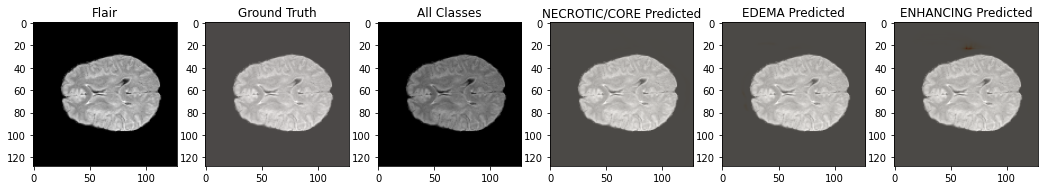

4/4 [==============================] - 0s 33ms/step


<Figure size 1296x3600 with 0 Axes>

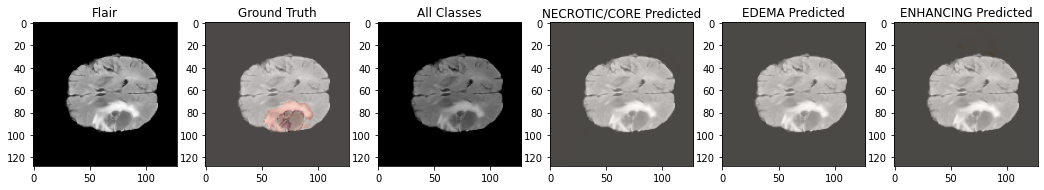

4/4 [==============================] - 0s 33ms/step


<Figure size 1296x3600 with 0 Axes>

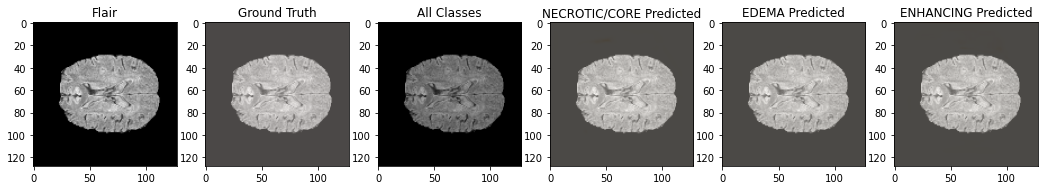

4/4 [==============================] - 0s 33ms/step


<Figure size 1296x3600 with 0 Axes>

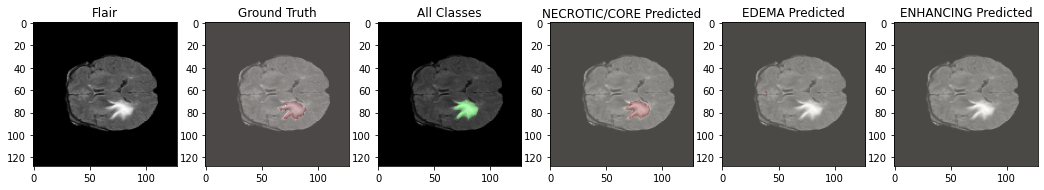

4/4 [==============================] - 0s 33ms/step


<Figure size 1296x3600 with 0 Axes>

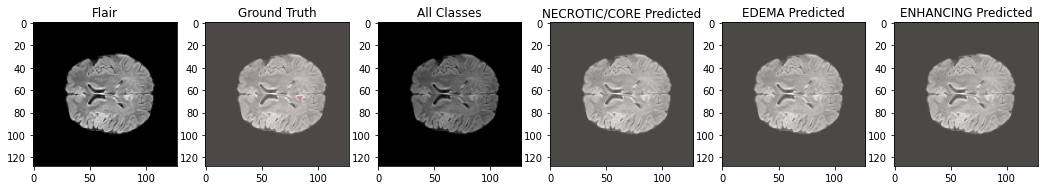

In [29]:
slice = 60


def view_predicted_data(index):
    data, image, gt = prepare_data_to_predict(TEST_LIST[index])
    p = model.predict(data/np.max(data), verbose=1)
    core = p[:, :, :, 1]
    edema = p[:, :, :, 2]
    enhancing = p[:, :, :, 3]
    plt.figure(figsize=(18, 50))
    f, axis_arr = plt.subplots(1, 6, figsize=(18, 50))
    for i in range(6):
        axis_arr[i].imshow(cv2.resize(image[:, :, slice + VOL_START],
                                      (IMG_SIZE, IMG_SIZE)), cmap="gray")

    axis_arr[0].imshow(cv2.resize(image[:, :, slice +
                                        VOL_START], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axis_arr[0].title.set_text('Flair')
    curr_gt = cv2.resize(gt[:, :, slice + VOL_START],
                         (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
    axis_arr[1].imshow(curr_gt, cmap="Reds", alpha=0.3)
    axis_arr[1].title.set_text('Ground Truth')
    axis_arr[2].imshow(p[slice, :, :, 1:4], cmap="Reds", alpha=0.3)
    axis_arr[2].title.set_text('All Classes')
    axis_arr[3].imshow(edema[slice, :, :], cmap="OrRd", alpha=0.3)
    axis_arr[3].title.set_text(f'{SEGMENT_CLASSES[1]} Predicted')
    axis_arr[4].imshow(core[slice, :, ], cmap="OrRd", alpha=0.3)
    axis_arr[4].title.set_text(f'{SEGMENT_CLASSES[2]} Predicted')
    axis_arr[5].imshow(enhancing[slice, :, ], cmap="OrRd", alpha=0.3)
    axis_arr[5].title.set_text(f'{SEGMENT_CLASSES[3]} Predicted')
    plt.show()


random_index = random.sample(range(len(TEST_LIST)), 5)
for i in random_index:
    view_predicted_data(i)

In [31]:
total_loss = sm.losses.categorical_focal_dice_loss
model.compile(loss=total_loss, optimizer=optim, metrics=['accuracy', tf.keras.metrics.MeanIoU(
    num_classes=4), sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)])
print("Evaluation on Test Data")
results = model.evaluate(test_generator, batch_size=100, callbacks=callbacks)
print("Test Loss, Test Acc:", results)

Evaluation on Test Data
24/24 [==============================] - 23s 869ms/step - loss: 0.3678 - accuracy: 0.9917 - mean_io_u: 0.9652 - iou_score: 0.5389 - f1-score: 0.6392
Test Loss, Test Acc: [0.3677983283996582, 0.9917113184928894, 0.9652100801467896, 0.5389294028282166, 0.6392187476158142]


In [32]:
def show_images(epochs, data, label):
    plt.figure()
    f, axarr = plt.subplots(1,2, figsize=(12,4)) 
    axarr[0].plot(epochs, data[0], 'y', label=f'Training {label[1]}')
    axarr[0].plot(epochs, data[1], 'r', label=f'Validation {label[1]}')
    axarr[0].set_title(f'Training and validation {label[1]}')
    axarr[0].set_xlabel(label[0])
    axarr[0].set_ylabel(label[1])
    axarr[0].legend()
    
    axarr[1].plot(epochs, data[2], 'y', label=f'Training {label[2]}')
    axarr[1].plot(epochs, data[3], 'r', label=f'Validation {label[2]}')
    axarr[1].set_title(f'Training and validation {label[2]}')
    axarr[1].set_xlabel(label[0])
    axarr[1].set_ylabel(label[2])
    axarr[1].legend()
    plt.show()

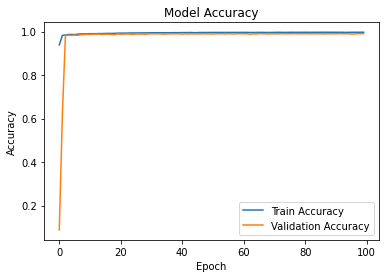

In [33]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train Accuracy', 'Validation Accuracy'], loc='lower right')
plt.show()

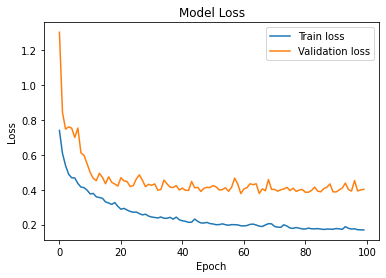

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Validation loss'], loc='upper right')
plt.show()

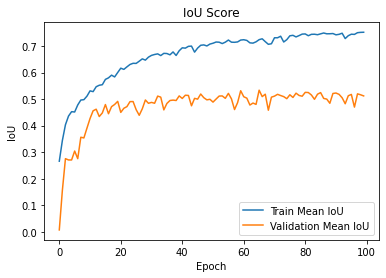

In [35]:
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('IoU Score')
plt.ylabel('IoU')
plt.xlabel('Epoch')
plt.legend(['Train Mean IoU', 'Validation Mean IoU'], loc='lower right')
plt.show()

In [36]:
# plt.plot(history.history['mean_io_u_1'])
# plt.plot(history.history['val_mean_io_u_1'])
# plt.title('Model Mean IoU')
# plt.ylabel('IoU')
# plt.xlabel('Epoch')
# plt.legend(['Train Mean IoU', 'Validation Mean IoU'], loc='lower right')
# plt.show()

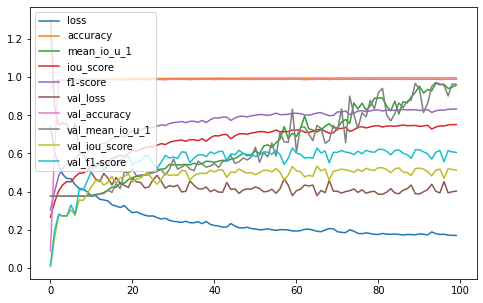

In [37]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()